In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load("en_core_web_sm")

In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [2]:
data_test_df = pd.read_csv("../../../Data/wikipedia_aggression/wp_agg_data_test_sample_1000.csv")
data_test_pos = data_test_df[data_test_df["oh_label"] == 1]
data_test_neg = data_test_df[data_test_df["oh_label"] == 0]

In [3]:
def return_pos_features(doc):
  text = []
  lemma = []
  pos = []
  tag = []
  dep = []
  shape = []
  is_alpha = []
  is_stop = []
  for token in doc:
      text.append(token.text)
      lemma.append(token.lemma_)
      pos.append(token.pos_)
      tag.append(token.tag_)
      dep.append(token.dep_)
      shape.append(token.shape_)
      is_alpha.append(token.is_alpha)
      is_stop.append(token.is_stop)
  featurs_df = pd.DataFrame.from_dict({"text":text,"lemma":lemma,"pos":pos,"tag":tag,"dep":dep,"shape":shape,"is_alpha":is_alpha,"is_stop":is_stop})
  return featurs_df

def return_NERT_featurs(docs):
  text = []
  ner_label = []
  for ent in docs.ents:
      text.append(ent.text)
      ner_label.append(ent.label_)
  featurs_df = pd.DataFrame.from_dict({"text":text,"ner_label":ner_label})
  return featurs_df

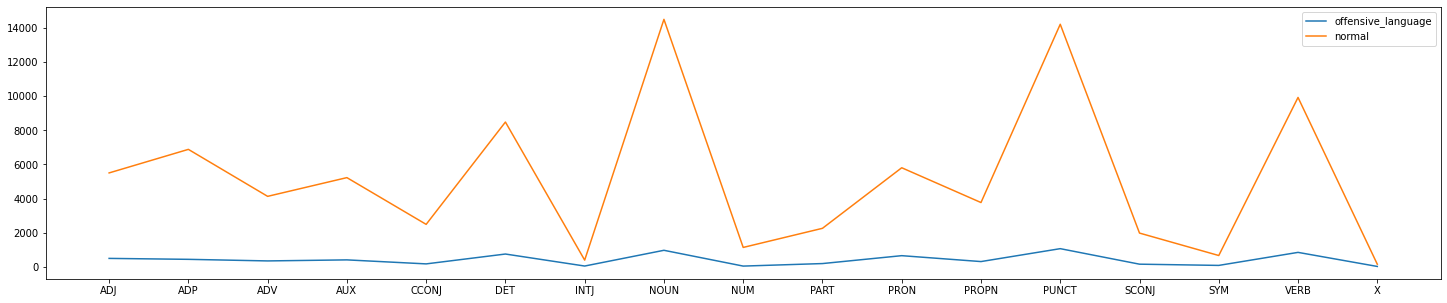

In [4]:
data_offensive_language_docs = "/n".join(data_test_pos["Text_clean_for_BERT"])
data_normal_docs = "/n".join(data_test_neg["Text_clean_for_BERT"])
data_offensive_language_docs_features = nlp(data_offensive_language_docs)
data_normal_docs_features = nlp(data_normal_docs)
data_normal_docs_features_df = return_pos_features(data_normal_docs_features) 
data_offensive_language_docs_features_df = return_pos_features(data_offensive_language_docs_features) 
import matplotlib.pyplot as plt
plt.subplots(figsize=(25, 5))
plt.plot(data_offensive_language_docs_features_df.groupby(data_offensive_language_docs_features_df["pos"]).pos.count(), label="offensive_language")
plt.plot(data_normal_docs_features_df.groupby(data_normal_docs_features_df["pos"]).pos.count(),label="normal")

plt.legend()

## get the attribution scores of all the unique words from BERT FT on WTP_agg 
## Tested on WTP agg DS

In [5]:
attribution_scores = pd.read_csv("attribution_scores/bert_with_fine_tuning/wikipedia_aggression_1000_data_fine_tuned_bert_attribution_scores.csv")

In [6]:
len(attribution_scores)

31244

In [7]:
attribution_scores["abs_attribution"] = [np.absolute(i) for i in attribution_scores.attribution]
word_attribution_grp = attribution_scores.groupby(attribution_scores["words"])
import numpy as np

unique_words = []
avg_attribution = []
avg_abs_attribution = []
no_occurances = []
for name,grp in word_attribution_grp:
    unique_words.append(name)
    avg_attribution.append(np.mean(grp["attribution"]))
    avg_abs_attribution.append(np.mean(grp["abs_attribution"]))
    no_occurances.append(len(grp["attribution"]))
word_attribution_unique = {}
word_attribution_unique["unique_words"] = unique_words
word_attribution_unique["attribution"] = avg_attribution
word_attribution_unique["abs_attribution"] = avg_abs_attribution
word_attribution_unique["No_occurences"] = no_occurances

word_attribution_unique_df = pd.DataFrame.from_dict(word_attribution_unique)
len(word_attribution_unique_df)

4195

In [8]:
word_attribution_unique_df.sort_values(by=["abs_attribution"],ascending=False)

,unique_words,attribution,abs_attribution,No_occurences
1946,dictatorship,-2.731324e+00,2.731324e+00,1
1675,cheat,1.352038e+00,1.352038e+00,2
3942,tt,9.707489e-01,9.707489e-01,1
499,##its,8.694808e-01,8.694808e-01,1
626,##maid,-8.035681e-01,8.035681e-01,1
...,...,...,...,...
1035,##tma,-2.041856e-06,2.041856e-06,1
153,##cer,1.607727e-06,1.607727e-06,1
1069,##uchi,-1.511907e-06,1.511907e-06,1
3144,ping,2.892657e-07,2.892657e-07,1


In [9]:
word_attribution_unique_df.to_csv("attribution_scores/bert_with_fine_tuning/wikipedia_aggression_1000_data_fine_tuned_bert_attribution_scores_grp_by_word.csv", index=False)

In [10]:
word_attribution_unique_df.corr()

,attribution,abs_attribution,No_occurences
attribution,1.000000,-0.047867,-0.000984
abs_attribution,-0.047867,1.000000,-0.007291
No_occurences,-0.000984,-0.007291,1.000000


## attribution scores of the linguistic features in normal text

In [11]:
def importance_score_of_ADJ_in_features (features):
    Twitter_rac_adj = features[features["pos"]=="ADJ"]
    adj_text = Twitter_rac_adj["text"].values
    attribution_adj = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in adj_text]
    adj_attribution = {}
    adj_attribution["adj"] = adj_text
    adj_attribution["adj_attribution"] = attribution_adj
    adj_attribution_df = pd.DataFrame.from_dict(adj_attribution)
    return adj_attribution_df
def importance_score_of_PRON_in_features (features):
    Twitter_rac_pron = features[features["pos"]=="PRON"]
    pron_text = Twitter_rac_pron["text"].values
    attribution_pron = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in pron_text]
    pron_attribution = {}
    pron_attribution["pron"] = pron_text
    pron_attribution["pron_attribution"] = attribution_pron
    pron_attribution_df = pd.DataFrame.from_dict(pron_attribution)
    return pron_attribution_df
def importance_score_of_DET_in_features (features):
    Twitter_rac_det = features[features["pos"]=="DET"]
    det_text = Twitter_rac_det["text"].values
    attribution_det = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in det_text]
    det_attribution = {}
    det_attribution["det"] = det_text
    det_attribution["det_attribution"] = attribution_det
    det_attribution_df = pd.DataFrame.from_dict(det_attribution)
    return det_attribution_df
def importance_score_of_ADV_in_features (features):
    Twitter_rac_adv = features[features["pos"]=="ADV"]
    adv_text = Twitter_rac_adv["text"].values
    attribution_adv = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in adv_text]
    adv_attribution = {}
    adv_attribution["adv"] = adv_text
    adv_attribution["adv_attribution"] = attribution_adv
    adv_attribution_df = pd.DataFrame.from_dict(adv_attribution)
    return adv_attribution_df
def importance_score_of_NOUN_in_features (features):
    Twitter_rac_noun = data_normal_docs_features_df[data_normal_docs_features_df["pos"]=="NOUN"]
    noun_text = Twitter_rac_noun["text"].values
    attribution_noun = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in noun_text]
    noun_attribution = {}
    noun_attribution["noun"] = noun_text
    noun_attribution["noun_attribution"] = attribution_noun
    noun_attribution_df = pd.DataFrame.from_dict(noun_attribution)
    return noun_attribution_df
def importance_score_of_VERB_in_features (features):
    Twitter_rac_verb = features[features["pos"]=="VERB"]
    verb_text = Twitter_rac_verb["text"].values
    attribution_verb = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in verb_text]
    verb_attribution = {}
    verb_attribution["verb"] = verb_text
    verb_attribution["verb_attribution"] = attribution_verb
    verb_attribution_df = pd.DataFrame.from_dict(verb_attribution)
    return verb_attribution_df
def importance_score_of_PUNCT_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="PUNCT"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    punc_attribution = {}
    punc_attribution["punc"] = punc_text
    punc_attribution["punc_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

In [12]:
adj_attribution_df_normal_txt = importance_score_of_ADJ_in_features(data_normal_docs_features_df)
pron_attribution_df_normal_txt = importance_score_of_PRON_in_features(data_normal_docs_features_df)
noun_attribution_df_normal_txt = importance_score_of_NOUN_in_features(data_normal_docs_features_df)
det_attribution_df_normal_txt = importance_score_of_DET_in_features(data_normal_docs_features_df)
verb_attribution_df_normal_txt = importance_score_of_VERB_in_features(data_normal_docs_features_df)
punc_attribution_df_normal_txt = importance_score_of_PUNCT_in_features(data_normal_docs_features_df)
adv_attribution_df_normal_txt = importance_score_of_ADV_in_features(data_normal_docs_features_df)

In [34]:
print("ADJ",np.mean(adj_attribution_df_normal_txt["adj_attribution"]))
print("PRON", np.mean(pron_attribution_df_normal_txt["pron_attribution"]))
print("NOUN",np.mean(noun_attribution_df_normal_txt["noun_attribution"]))
print("DET",np.mean(det_attribution_df_normal_txt["det_attribution"]))
print("VERB",np.mean(verb_attribution_df_normal_txt["verb_attribution"]))
print("PUNC",np.mean(punc_attribution_df_normal_txt["punc_attribution"]))
print("ADV",np.mean( adv_attribution_df_normal_txt["adv_attribution"]))

ADJ 0.018958778103817988
PRON 0.02581352060724861
NOUN 0.018052007094780446
DET 0.020828647328796194
VERB 0.020490600814419536
PUNC 0.0
ADV 0.016801590271678803


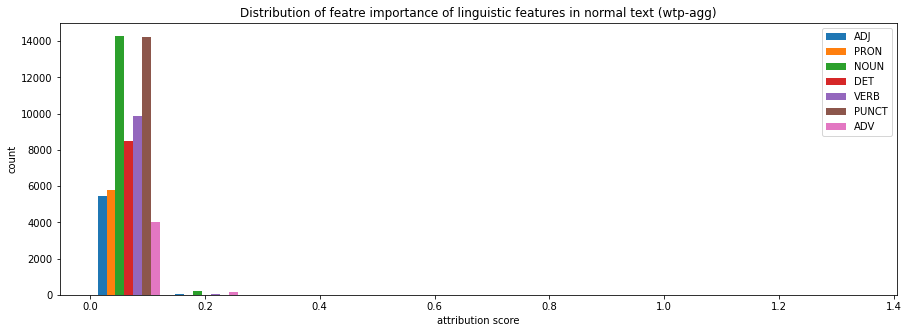

In [13]:
plt.subplots(figsize=(15, 5))
plt.hist([adj_attribution_df_normal_txt["adj_attribution"],
          pron_attribution_df_normal_txt["pron_attribution"],
          noun_attribution_df_normal_txt["noun_attribution"],
          det_attribution_df_normal_txt["det_attribution"],
         verb_attribution_df_normal_txt["verb_attribution"],
          punc_attribution_df_normal_txt["punc_attribution"],
         adv_attribution_df_normal_txt["adv_attribution"]],
         label=["ADJ","PRON","NOUN","DET","VERB","PUNCT","ADV"], stacked=False)
plt.xlabel("attribution score")
plt.ylabel("count")
plt.title("Distribution of featre importance of linguistic features in normal text (wtp-agg)")
plt.legend()

## attribution scores of the linguistic features in avusive text

In [14]:
adj_attribution_df_offens_txt = importance_score_of_ADJ_in_features(data_offensive_language_docs_features_df)
pron_attribution_df_offens_txt = importance_score_of_PRON_in_features(data_offensive_language_docs_features_df)
noun_attribution_df_offens_txt = importance_score_of_NOUN_in_features(data_offensive_language_docs_features_df)
det_attribution_df_offens_txt = importance_score_of_DET_in_features(data_offensive_language_docs_features_df)
verb_attribution_df_offens_txt = importance_score_of_VERB_in_features(data_offensive_language_docs_features_df)
punc_attribution_df_offens_txt = importance_score_of_PUNCT_in_features(data_offensive_language_docs_features_df)
adv_attribution_df_offens_txt = importance_score_of_ADV_in_features(data_offensive_language_docs_features_df)

In [30]:
punc_attribution_df_offens_txt

,punc,punc_attribution
0,=,0
1,=,0
2,?,0
3,/n,0
4,:,0
...,...,...
1055,...,0
1056,.now,0
1057,?,0
1058,?,0


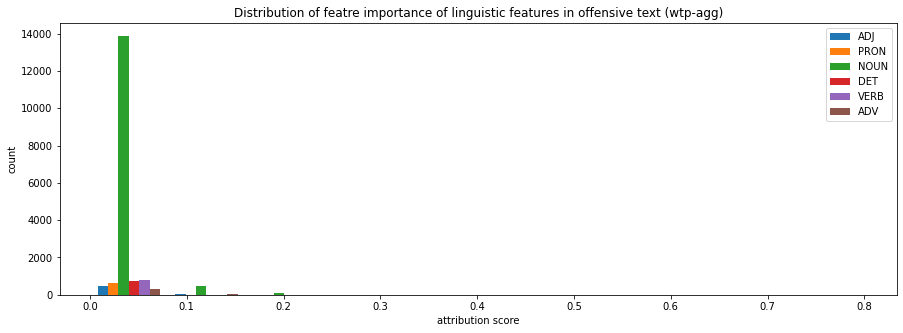

In [26]:
plt.subplots(figsize=(15, 5))
plt.hist([adj_attribution_df_offens_txt["adj_attribution"],
          pron_attribution_df_offens_txt["pron_attribution"],
          noun_attribution_df_offens_txt["noun_attribution"],
          det_attribution_df_offens_txt["det_attribution"],
         verb_attribution_df_offens_txt["verb_attribution"],
         adv_attribution_df_offens_txt["adv_attribution"]],
         label=["ADJ","PRON","NOUN","DET","VERB","ADV"], stacked=False)
plt.xlabel("attribution score")
plt.ylabel("count")
plt.title("Distribution of featre importance of linguistic features in offensive text (wtp-agg)")
plt.legend()

In [33]:
print("ADJ",np.mean(adj_attribution_df_offens_txt["adj_attribution"]))
print("PRON", np.mean(pron_attribution_df_offens_txt["pron_attribution"]))
print("NOUN",np.mean(noun_attribution_df_offens_txt["noun_attribution"]))
print("DET",np.mean(det_attribution_df_offens_txt["det_attribution"]))
print("VERB",np.mean(verb_attribution_df_offens_txt["verb_attribution"]))
print("PUNC",np.mean(punc_attribution_df_offens_txt["punc_attribution"]))
print("ADV",np.mean( adv_attribution_df_offens_txt["adv_attribution"]))

ADJ 0.02877124109588692
PRON 0.02870507416428997
NOUN 0.018052007094780446
DET 0.018374036370407017
VERB 0.030871796197541997
PUNC 0.0
ADV 0.022408464096610584
